<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/week10/aggregate_data_with_distance_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First I reduced the 16 GB data to 5 GB with only the county_code, date, device_count, and distance_traveled column. I did that on my own machine and then I uploaded the 5 GB data to google drive. In this notebook I will try to aggregate data of the same county on the same date, and then visualize the distance traveled vs date as a time series.

In [1]:
ls

drive/  sample_data/


In [2]:
cd drive/My\ Drive/week8

/content/drive/My Drive/week8


In [3]:
ls

 2016_US_County_Level_Presidential_Results.csv
 2019_data.csv
'2020 County Health Rankings Data - Additional Measure Data.csv'
'2020 County Health Rankings Data - Ranked Measure Data.csv'
 2020_data.csv
 check_if_data_is_alright.ipynb
'Copy of agg_social_dist_2.csv'
 county_data_with_covariates.csv
 county_data_with_reduced_covariates.csv
 county_data_with_reduced_covariates_up_to_2020-8-8.csv
 county_data_with_reduced_covariates_with_SIP.csv
 county_data_with_reduced_covariates_with_SIP_up_to_5.csv
 county_data_with_reduced_covariates_with_SIP_up_to_8.csv
 data_2019_agg.csv
 data_2020_agg.csv
 data_for_propensity.csv
 days_since.csv
 merged_data.csv
 prepare_data_distance.ipynb
 prepare_data_with_SIP_date.ipynb
 prepare_new_data.ipynb
 propensity_score_matching_after_SIP.ipynb
 social_dist_aggregated_on_county.csv
 social_dist_all_reduced_2.csv
 social_dist_all_trimmed.csv
 social_dist_all_trimmed_new.csv
 social_dist_low_device_count_filtered.csv
 social_dist_reduced.csv
 us_states_g

In [4]:
import pandas as pd
import numpy as np

In [5]:
data = pd.read_csv("social_dist_all_reduced_2.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
data.shape

(128512309, 4)

In [7]:
data.head()

,date_range_start,county_code,device_count,distance_traveled_from_home
0,2019-01-01T00:00:00-06:00,1033,78,687
1,2019-01-01T00:00:00-06:00,1073,259,5381
2,2019-01-01T00:00:00-06:00,1121,91,1591
3,2019-01-01T00:00:00-06:00,1125,392,4623
4,2019-01-01T00:00:00-09:00,2188,10,0


Now we want to aggregate data of the same county on the same date somehow. Obviously we can't just add up numbers anymore because distance_traveled_from_home is the average distance_traveled by all the people in that county. [Look at the data schema here](https://docs.safegraph.com/docs/social-distancing-metrics). We have to a weighted average thing like we did before. weights being the device_count

In [90]:
# weighted mean function
wm = lambda x: np.average(x, weights= data.loc[x.index, "device_count"])

In [91]:
data = pd.read_csv("social_dist_all_reduced_2.csv", nrows = 100000)

In [92]:
data.groupby(['date_range_start', 'county_code']).\
    agg(distance_traveled_from_home = ('distance_traveled_from_home', wm)).reset_index()

,date_range_start,county_code,distance_traveled_from_home
0,2019-01-01T00:00:00+10:00,66010,1462.272590
1,2019-01-01T00:00:00+10:00,69100,0.000000
2,2019-01-01T00:00:00+10:00,69110,1158.423858
3,2019-01-01T00:00:00+10:00,69120,0.000000
4,2019-01-01T00:00:00-04:00,23029,1028.132075
...,...,...,...
3148,2019-01-01T00:00:00-10:00,15003,4175.332758
3149,2019-01-01T00:00:00-10:00,15007,2728.143320
3150,2019-01-01T00:00:00-10:00,15009,2101.682410
3151,2019-01-01T00:00:00-11:00,60010,0.000000


We see that the distance_traveled by county 66010 on 2019-01-01 is 1462 by our aggregation with weighted mean function. Let's check if that is true manually.

In [93]:
# first get all the data about county 66010 on 2019-01-01
small_data = data[(data['date_range_start'] == '2019-01-01T00:00:00+10:00') & (data['county_code'] == 66010)]

In [94]:
small_data.head()

,date_range_start,county_code,device_count,distance_traveled_from_home
501,2019-01-01T00:00:00+10:00,66010,8,0
1967,2019-01-01T00:00:00+10:00,66010,11,110
3576,2019-01-01T00:00:00+10:00,66010,27,2656
4747,2019-01-01T00:00:00+10:00,66010,20,766
6407,2019-01-01T00:00:00+10:00,66010,17,0


In [95]:
# product = all the meters traveled by that subgroup on that date.
small_data['product'] = small_data['device_count'] * small_data['distance_traveled_from_home']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
small_data

,date_range_start,county_code,device_count,distance_traveled_from_home,product
501,2019-01-01T00:00:00+10:00,66010,8,0,0
1967,2019-01-01T00:00:00+10:00,66010,11,110,1210
3576,2019-01-01T00:00:00+10:00,66010,27,2656,71712
4747,2019-01-01T00:00:00+10:00,66010,20,766,15320
6407,2019-01-01T00:00:00+10:00,66010,17,0,0
...,...,...,...,...,...
93241,2019-01-01T00:00:00+10:00,66010,20,2685,53700
95400,2019-01-01T00:00:00+10:00,66010,21,307,6447
95622,2019-01-01T00:00:00+10:00,66010,24,1991,47784
95623,2019-01-01T00:00:00+10:00,66010,26,3280,85280


In [97]:
# all the meters traveled by all the people /
# number of all the people = 
# mean distance traveled by county 66010 on date 2019-01-01
small_data['product'].sum() / small_data['device_count'].sum()

1462.2725903614457

We can see that our result from manual calculation is 1462, which is the same answer as the one we calculated with the mean weighted function. So we can trust that our weighted mean function does what it is supposed to do.

Now let's check if chunk sized process will work too. Let's still read in 100000 rows as before, but read in 10000 row at a time and do aggregation with weighted sum, and let's see if in the end it gives the same result.

In [98]:
# import library for parsing date objects
from datetime import datetime

In [99]:
# redefine the function to use aggregatedData instead of data
wm = lambda x: np.average(x, weights= aggregatedData.loc[x.index, "device_count"])

In [103]:
aggregatedData = pd.read_csv("social_dist_all_reduced_2.csv", nrows = 0,\
                             dtype = {'date_range_start': 'datetime64[ns]',\
                                      'county_code': 'float64', \
                                      'device_count': 'float64', \
                                      'distance_traveled_from_home': 'float64'})

In [104]:
counter = 0
for chunk in pd.read_csv("social_dist_all_reduced_2.csv", chunksize = 10000, nrows = 100000):
    # convert chunk's columns to the right datatype.
    chunk['device_count'] = pd.to_numeric(chunk['device_count'], errors='coerce')
    chunk['county_code'] = pd.to_numeric(chunk['county_code'], errors='coerce')
    chunk['distance_traveled_from_home'] = pd.to_numeric(chunk['distance_traveled_from_home'], errors='coerce')
    # drop the null rows (get rid of the row that is header)
    # also gets rid of 2 counties whose FIPS code is null.
    chunk.dropna(inplace = True)
    # convert string column to datetime object
    
    chunk['date_range_start'] = chunk['date_range_start'].apply(lambda x: datetime.strptime(x[0:10], '%Y-%m-%d'))
    
    # groupby and aggregate data of the same county of the same date.
    aggregatedData = aggregatedData.append(chunk, ignore_index = True)
    aggregatedData = aggregatedData.groupby(['date_range_start', 'county_code'])\
        .agg(device_count = ('device_count', 'sum'),\
             distance_traveled_from_home = ('distance_traveled_from_home', wm)).reset_index()
    
    print(counter) # track progress
    print(aggregatedData.shape[0]) # how large is our data right now
    counter += 1

0
1942
1
2468
2
2703
3
2847
4
2947
5
3020
6
3070
7
3105
8
3126
9
3141


In [105]:
aggregatedData[aggregatedData['county_code'] == 66010]

,date_range_start,county_code,device_count,distance_traveled_from_home
3056,2019-01-01,66010.0,1328.0,1462.27259


We see that in chunk sized processes we still get the correct result of 1462 for county 66010 for 2019-01-01. Now we can apply this chunk sized process to the entire dataset.

In [106]:
aggregatedData = pd.read_csv("social_dist_all_reduced_2.csv", nrows = 0,\
                             dtype = {'date_range_start': 'datetime64[ns]',\
                                      'county_code': 'float64', \
                                      'device_count': 'float64', \
                                      'distance_traveled_from_home': 'float64'})

In [ ]:
counter = 0
for chunk in pd.read_csv("social_dist_all_reduced_2.csv", chunksize = 1000000):
    # convert chunk's columns to the right datatype.
    chunk['device_count'] = pd.to_numeric(chunk['device_count'], errors='coerce')
    chunk['county_code'] = pd.to_numeric(chunk['county_code'], errors='coerce')
    chunk['distance_traveled_from_home'] = pd.to_numeric(chunk['distance_traveled_from_home'], errors='coerce')
    # drop the null rows (get rid of the row that is header)
    # also gets rid of 2 counties whose FIPS code is null.
    chunk.dropna(inplace = True)
    # convert string column to datetime object
    
    chunk['date_range_start'] = chunk['date_range_start'].apply(lambda x: datetime.strptime(x[0:10], '%Y-%m-%d'))
    
    # groupby and aggregate data of the same county of the same date.
    aggregatedData = aggregatedData.append(chunk, ignore_index = True)
    aggregatedData = aggregatedData.groupby(['date_range_start', 'county_code'])\
        .agg(device_count = ('device_count', 'sum'),\
             distance_traveled_from_home = ('distance_traveled_from_home', wm)).reset_index()
    
    print(counter) # track progress
    print(aggregatedData.shape[0]) # how large is our data right now
    counter += 1

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0
16087
1
31660
2
45163
3
61048
4
74228
5
90244
6
103290
7
119347
8
132346
9
148438
10
163925
11
177508
12
193364
13
206575
14
222566
15
235638
16
251688
17
264695
18
280779
19
296179
20
309855
21
325689
22
338919
23
354906
24
367980
25
384026
26
397033
27
413112
28
428489
29
442169
30
458002
31
471235
32
487231
33
500294
34
516348
35
529348
36
545428
37
560897
38
574507
39
590375
40
603565
41
619580
42
632628
43
648683
44
662398
45
677763
46
693401
47
706834
48
722752
49
735897
50
751930
51
764951
52
781014
53
795835
54
810087
55
825822
56
839162
57
855112
58
868228
59
884273
60
897282
61
913349
62
928697


KeyboardInterrupt: ignored

This way of using weighted mean function is way too slow. Ran the above cell for 4 - 5 hours and it only got to iteration 60 -> we need to get to iteration 120. maybe doing floating point multiplication is computationally more expensive. Below I will use the products and summing up products way of calculating the distance. This way we only do multiplication and addition, which are simpler. Only thing is this way product will get out of control - but python has infinite range for integers, so we are good. 

In [13]:
aggregatedData = pd.read_csv("social_dist_all_reduced_2.csv", nrows = 0,\
                             dtype = {'date_range_start': 'datetime64[ns]',\
                                      'county_code': 'float64', \
                                      'device_count': 'float64', \
                                      'distance_traveled_from_home': 'float64'})

In [16]:
counter = 0
for chunk in pd.read_csv("social_dist_all_reduced_2.csv", chunksize = 1000000):
    # convert chunk's columns to the right datatype.
    chunk['device_count'] = pd.to_numeric(chunk['device_count'], errors='coerce')
    chunk['county_code'] = pd.to_numeric(chunk['county_code'], errors='coerce')
    chunk['distance_traveled_from_home'] = pd.to_numeric(chunk['distance_traveled_from_home'], errors='coerce')
    # drop the null rows (get rid of the row that is header)
    chunk.dropna(inplace = True)

    # convert string column to datetime object
    chunk['date_range_start'] = chunk['date_range_start'].apply(lambda x: datetime.strptime(x[0:10], '%Y-%m-%d'))

    # calculate the total distances traveled by this county's people.
    # will just be mean distance traveled times number of devices.
    # don't need to worry about overflow because python doesn't have limit on how large integers are.

    # let's just use distance_traveled_from_home as the column for the total distance traveled
    # we could create a new column, but this way wouldn't waste a lot of space.
    chunk['distance_traveled_from_home'] = chunk['distance_traveled_from_home'] * chunk['device_count']
    chunk = chunk.groupby(['date_range_start', 'county_code']).agg(device_count = ('device_count', 'sum'),\
                                                                   distance_traveled_from_home = ('distance_traveled_from_home', 'sum')).reset_index()
    
    # groupby and aggregate data of the same county of the same date.
    aggregatedData = aggregatedData.append(chunk, ignore_index = True)
    aggregatedData = aggregatedData.groupby(['date_range_start', 'county_code'])\
        .agg(device_count = ('device_count', 'sum'),\
             distance_traveled_from_home = ('distance_traveled_from_home', 'sum')).reset_index()
    
    print(counter) # track progress
    print(aggregatedData.shape[0]) # how large is our data right now
    counter += 1

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0
16087
1
31660
2
45163
3
61048
4
74228
5
90244
6
103290
7
119347
8
132346
9
148438
10
163925
11
177508
12
193364
13
206575
14
222566
15
235638
16
251688
17
264695
18
280779
19
296179
20
309855
21
325689
22
338919
23
354906
24
367980
25
384026
26
397033
27
413112
28
428489
29
442169
30
458002
31
471235
32
487231
33
500294
34
516348
35
529348
36
545428
37
560897
38
574507
39
590375
40
603565
41
619580
42
632628
43
648683
44
662398
45
677763
46
693401
47
706834
48
722752
49
735897
50
751930
51
764951
52
781014
53
795835
54
810087
55
825822
56
839162
57
855112
58
868228
59
884273
60
897282
61
913349
62
928697
63
942415
64
958291
65
971464
66
987478
67
1000507
68
1016571
69
1031905
70
1045633
71
1061520
72
1074693
73
1090711
74
1103731
75
1119793
76
1134935
77
1148877
78
1164713
79
1177944
80
1193919
81
1207008
82
1223064
83
1236065
84
1252150
85
1267682
86
1281226
87
1297110
88
1310276
89
1326269
90
1339304
91
1355356
92
1369876
93
1384421
94
1400096
95
1413496
96
1429420
97
1442563
98
14

In [100]:
aggregatedData.head()

,date_range_start,county_code,device_count,distance_traveled_from_home
0,2019-01-01,1001.0,4708.0,13986801.0
1,2019-01-01,1003.0,19655.0,58166713.0
2,2019-01-01,1005.0,1570.0,3416426.0
3,2019-01-01,1007.0,1702.0,6452161.0
4,2019-01-01,1009.0,5224.0,18259566.0


In [102]:
aggregatedData.to_csv("aggregated_data_on_distance.csv", index = False)

Now let's check if this aggregatedData is correct.

In [107]:
aggregatedData = pd.read_csv("aggregated_data_on_distance.csv", parse_dates=['date_range_start'], infer_datetime_format=True)

In [108]:
aggregatedData.head()

,date_range_start,county_code,device_count,distance_traveled_from_home
0,2019-01-01,1001.0,4708.0,13986801.0
1,2019-01-01,1003.0,19655.0,58166713.0
2,2019-01-01,1005.0,1570.0,3416426.0
3,2019-01-01,1007.0,1702.0,6452161.0
4,2019-01-01,1009.0,5224.0,18259566.0


Let's use Guam data on the first date to see if our aggregated data's distance matches the distance calculated from original dataset.

In [30]:
firstMillionData = pd.read_csv('social_dist_all_reduced_2.csv', nrows = 1000000)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
firstMillionData[firstMillionData['county_code'] == '66010']

,date_range_start,county_code,device_count,distance_traveled_from_home
132081,2019-01-01T00:00:00+10:00,66010,21,1048
135041,2019-01-01T00:00:00+10:00,66010,11,0
135258,2019-01-01T00:00:00+10:00,66010,21,3537
137393,2019-01-01T00:00:00+10:00,66010,14,5738
139098,2019-01-01T00:00:00+10:00,66010,19,600
...,...,...,...,...
913885,2019-01-05T00:00:00+10:00,66010,12,2611
914567,2019-01-05T00:00:00+10:00,66010,19,7155
914807,2019-01-05T00:00:00+10:00,66010,24,1610
915493,2019-01-05T00:00:00+10:00,66010,31,1828


In [40]:
firstMillionData[firstMillionData['county_code'] == 66010]

,date_range_start,county_code,device_count,distance_traveled_from_home
501,2019-01-01T00:00:00+10:00,66010,8,0
1967,2019-01-01T00:00:00+10:00,66010,11,110
3576,2019-01-01T00:00:00+10:00,66010,27,2656
4747,2019-01-01T00:00:00+10:00,66010,20,766
6407,2019-01-01T00:00:00+10:00,66010,17,0
...,...,...,...,...
993832,2019-01-05T00:00:00+10:00,66010,13,93
994036,2019-01-05T00:00:00+10:00,66010,18,0
994476,2019-01-05T00:00:00+10:00,66010,25,2204
994477,2019-01-05T00:00:00+10:00,66010,22,4669


In [36]:
guamStringData = firstMillionData[firstMillionData['county_code'] == '66010']

In [37]:
guamIntData = firstMillionData[firstMillionData['county_code'] == 66010]

In [42]:
guamData = guamStringData.append(guamIntData, ignore_index=True)

In [44]:
guamData['device_count'] = pd.to_numeric(guamData['device_count'], errors='coerce')
guamData['county_code'] = pd.to_numeric(guamData['county_code'], errors='coerce')
guamData['distance_traveled_from_home'] = pd.to_numeric(guamData['distance_traveled_from_home'], errors='coerce')

In [45]:
guamData.dtypes

date_range_start               object
county_code                     int64
device_count                    int64
distance_traveled_from_home     int64
dtype: object

In [46]:
wm = lambda x: np.average(x, weights= guamData.loc[x.index, "device_count"])

In [47]:
guamData.groupby(['date_range_start', 'county_code'])\
        .agg(device_count = ('device_count', 'sum'),\
             distance_traveled_from_home = ('distance_traveled_from_home', wm)).reset_index()

,date_range_start,county_code,device_count,distance_traveled_from_home
0,2019-01-01T00:00:00+10:00,66010,3006,1671.811045
1,2019-01-02T00:00:00+10:00,66010,2904,15212.669766
2,2019-01-03T00:00:00+10:00,66010,2925,1637.065983
3,2019-01-04T00:00:00+10:00,66010,3364,1573.140904
4,2019-01-05T00:00:00+10:00,66010,1940,1719.977835


So our original dataset gives 1671 of distance on 2019-01-01 for Guam. Let'see if that is the case for aggregatedData.

In [18]:
aggregatedData[aggregatedData['county_code'] == 66010]

,date_range_start,county_code,device_count,distance_traveled_from_home
3143,2019-01-01,66010.0,3006.0,5025464.0
6371,2019-01-02,66010.0,2904.0,44177593.0
9599,2019-01-03,66010.0,2925.0,4788418.0
12827,2019-01-04,66010.0,3364.0,5292046.0
16055,2019-01-05,66010.0,3383.0,6306407.0
...,...,...,...,...
1877960,2020-08-04,66010.0,4712.0,23205415.0
1881187,2020-08-05,66010.0,4750.0,10777636.0
1884415,2020-08-06,66010.0,4882.0,11214204.0
1887643,2020-08-07,66010.0,4703.0,10791592.0


In [111]:
guamData = aggregatedData[aggregatedData['county_code'] == 66010]

In [114]:
guamData.iloc[0]['distance_traveled_from_home'] / guamData.iloc[0]['device_count'] 

1671.8110445775117

This aggregatedData gives the same number 1671 for Guam on 2029-01-01 as the one given directly from original dataset. So we can trust our aggregation process.

Now we can plot the time series of mean distance traveled vs date.

In [28]:
import matplotlib.pyplot as plt

In [115]:
# look at LA
small_data = aggregatedData[aggregatedData['county_code'] == 6037]

In [116]:
small_data

,date_range_start,county_code,device_count,distance_traveled_from_home
204,2019-01-01,6037.0,579809.0,1.682515e+09
3432,2019-01-02,6037.0,583477.0,1.881154e+09
6660,2019-01-03,6037.0,585075.0,1.453021e+09
9888,2019-01-04,6037.0,586509.0,1.494154e+09
13116,2019-01-05,6037.0,601512.0,1.515549e+09
...,...,...,...,...
1875021,2020-08-04,6037.0,399415.0,9.292363e+08
1878249,2020-08-05,6037.0,409204.0,1.060004e+09
1881476,2020-08-06,6037.0,415331.0,1.023325e+09
1884704,2020-08-07,6037.0,410583.0,1.103181e+09


In [118]:
small_data['mean_distance_traveled'] = small_data['distance_traveled_from_home'] / small_data['device_count']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


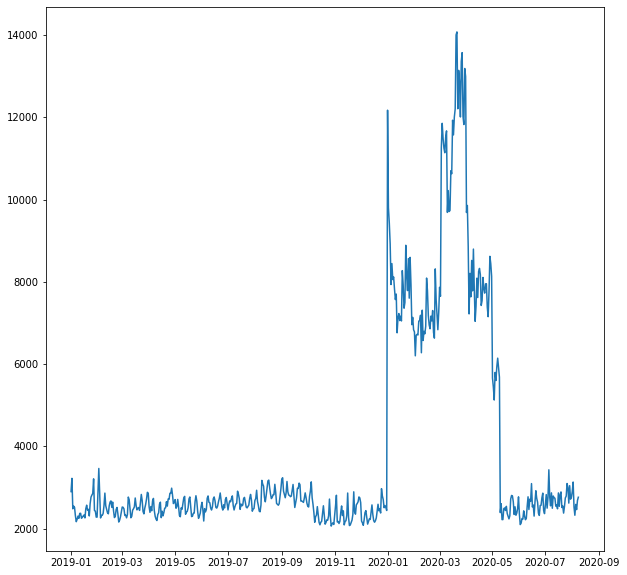

In [119]:
plt.figure(figsize = (10,10))
plt.plot(small_data['date_range_start'], small_data['mean_distance_traveled'])

We can see the distance traveled spiked from 2020-01-01 to 2020-04-01. Why do people travel more when pandamic is here?

In [120]:
# look at king county
small_data = aggregatedData[aggregatedData['county_code'] == 53033]

In [121]:
small_data['mean_distance_traveled'] = small_data['distance_traveled_from_home'] / small_data['device_count']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


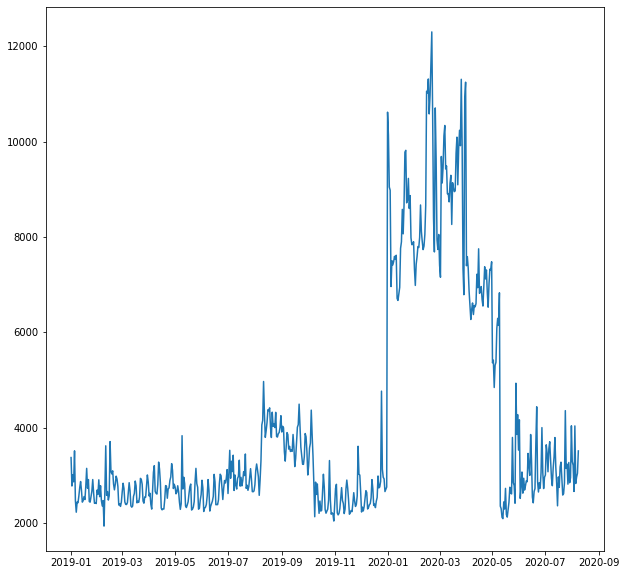

In [122]:
plt.figure(figsize = (10,10))
plt.plot(small_data['date_range_start'], small_data['mean_distance_traveled'])

King county's data follows the same trajectory. the y-axis is meters traveled per day by the way.

Is this an anomaly? Maybe what we see is only King county and LA county? Let's compare mean distance for all the counties from 2020 January to March and the mean distance from March to May. 

In [80]:
data_from_1_to_3 = aggregatedData[(aggregatedData['date_range_start'] >= datetime(2020, 1, 1)) & 
                                  (aggregatedData['date_range_start'] <= datetime(2020, 3, 1))]

In [81]:
data_from_3_to_5 = aggregatedData[(aggregatedData['date_range_start'] > datetime(2020, 3, 1)) & 
                                  (aggregatedData['date_range_start'] <= datetime(2020, 5, 1))]

In [82]:
data_from_1_to_3.head()

,date_range_start,county_code,device_count,distance_traveled_from_home
1177962,2020-01-01,1001.0,5501.0,54655284.0
1177963,2020-01-01,1003.0,20761.0,208217049.0
1177964,2020-01-01,1005.0,1660.0,12815121.0
1177965,2020-01-01,1007.0,2040.0,24223963.0
1177966,2020-01-01,1009.0,6206.0,69518936.0


In [83]:
data_from_3_to_5.head()

,date_range_start,county_code,device_count,distance_traveled_from_home
1374786,2020-03-02,1001.0,6077.0,64030737.0
1374787,2020-03-02,1003.0,25887.0,708772239.0
1374788,2020-03-02,1005.0,1874.0,19281152.0
1374789,2020-03-02,1007.0,2327.0,29741260.0
1374790,2020-03-02,1009.0,6987.0,100145797.0


In [87]:
data_from_1_to_3['distance_traveled_from_home'].sum() / data_from_1_to_3['device_count'].sum()

9586.87184912101

In [88]:
data_from_3_to_5['distance_traveled_from_home'].sum() / data_from_3_to_5['device_count'].sum()

10604.962580333793

As we can see from Jaunary to March 2020, people travel 9586 meters per day averaged over all counties, and from March to May, it is 10604, so people's traveling behavior increased.. Why?!